In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import plotly.express as px
import matplotlib.pyplot as plt
import glob
import matplotlib.dates as mdates
import mplcyberpunk as mp
from colorama import Fore, Style

In [78]:
def baixar_dados(ticker, start_date, end_date):
    data = yf.download(
        tickers=ticker,
        start=start_date,
        end = end_date,
        interval="5m"
        # start: Data de início no formato YYYY-MM-DD.
        # interval: Frequência dos dados (opções: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo)
    )
    try:
        dados = yf.download(ticker, start=start_date, end=end_date, interval="1d")
        data.iloc[-1,3] = dados.iloc[-1, 3]
        return data
    except:
        return data

def buscar_dados_diarios():
    dfs = []  
    now = datetime.now()
    if now.weekday() == 5:  # Sábado
        now = now - timedelta(days=1)  # Retrocede para sexta
    elif now.weekday() == 6:  # Domingo
        now = now - timedelta(days=2)  # Retrocede para sexta

    end_day = now.day
    end_date = (now + timedelta(days=1)).strftime("%Y-%m-%d")

    if now.weekday() == 7: now = now - timedelta(days=3) # Retrocede para sexta
    date_previous = now - timedelta(days=1)
    start_day = date_previous.day    
    start_date = date_previous.strftime("%Y-%m-%d")

    brasil_tickers =  ['ABEV3.SA', 'ALPA4.SA',  'ASAI3.SA', 'AZUL4.SA', 'B3SA3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BEEF3.SA', 'BPAC11.SA','BRAP4.SA',
                       'BRFS3.SA', 'BRKM5.SA',  'CASH3.SA', 'CCRO3.SA', 'CMIG4.SA', 'CPFE3.SA', 'CRFB3.SA', 'CSAN3.SA', 'CVCB3.SA', 'CYRE3.SA', 'DXCO3.SA', 'ECOR3.SA',
                       'EGIE3.SA', 'ELET3.SA',  'ELET6.SA', 'EMBR3.SA', 'ENEV3.SA', 'ENGI11.SA','EQTL3.SA', 'EZTC3.SA', 'GGBR4.SA', 'GOAU4.SA', 'GOLL4.SA', 'HAPV3.SA',
                       'IGTI11.SA','IRBR3.SA',  'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'JHSF3.SA', 'KLBN11.SA','LREN3.SA', 'MGLU3.SA', 'MRFG3.SA', 'MRVE3.SA', 'MULT3.SA',
                       'NTCO3.SA', 'HYPE3.SA',  'PETR3.SA', 'PETR4.SA', 'POSI3.SA', 'PRIO3.SA', 'QUAL3.SA', 'RADL3.SA' ,'RAIL3.SA', 'RENT3.SA', 'SANB11.SA','SBSP3.SA',
                       'SAPR4.SA', 'SAPR11.SA', 'SUZB3.SA', 'TAEE11.SA','TRPL4.SA', 'TOTS3.SA', 'UGPA3.SA', 'USIM5.SA','VALE3.SA', 'BRBI11.SA', 'RAIZ4.SA', 'RANI3.SA',
                       'KLBN3.SA', 'KLBN4.SA', 'KLBN11.SA']
    brasil_tickers =  ['VALE3.SA', 'BBAS3.SA',  'SAPR4.SA']
    
    for acao in brasil_tickers:
        dados_diarios = baixar_dados(acao, start_date, end_date)
        dados_diarios['variacao'] = dados_diarios['Close'].pct_change()     
        dados_diarios['variacao'] = dados_diarios['variacao'].apply(lambda x: round(x * 100, 4))
        dados_diarios['variacao'] = (1 + dados_diarios['variacao']).cumprod() - 1
        dados_diarios = dados_diarios.loc[:, ['Close', 'Volume', 'variacao']]
        dados_diarios['acao'] = acao.replace('.SA', '')  # Adiciona a coluna com o nome da ação
        dados_diarios = dados_diarios.reset_index()
        dfs.append(dados_diarios)

    
    # união dos dfs
    resultado = pd.concat(dfs, ignore_index=True)
    resultado['Datetime'] = pd.to_datetime(resultado['Datetime'])
    resultado['day'] = resultado['Datetime'].dt.day
    resultado.to_csv('df_day.csv', index=False)

    # dados do dia anterior
    dados_start_day = resultado.loc[resultado['day'] == start_day, :]
    dados_start_day.to_csv('df_day_before.csv', index=False)

    # dados ultimo dia
    dados_end_day = resultado.loc[resultado['day'] == end_day, :]
    dados_end_day.to_csv('df_day.csv', index=False)

        
buscar_dados_diarios()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## def gráfico e mensagem

In [86]:
def grafico(df1, lista_acoes, mean=False):
    plt.style.use("cyberpunk")
    # plt.style.use("Solarize_Light2")
    # plt.style.use("default")

    tam_geral = 12
    all_variacoes = []
    lista_legend = []

    fig, fig_acoes1 = plt.subplots(figsize = (tam_geral,tam_geral/2))

    for acao in lista_acoes:
        df_aux = df1.loc[df1['acao']==acao,:].copy()
        if df_aux.empty:
            print(f'Ação não encontrada: {acao}')
        else:
            lista_legend.append(acao)
        df_aux['variacao'] = df_aux['Close'].pct_change() 
        df_aux['variacao'] = (1 + df_aux['variacao']).cumprod() - 1
        df_aux['variacao'] = df_aux['variacao'].apply(lambda x: round(x * 100, 5))

        df_aux['variacao'] = df_aux['variacao'].fillna(0)
        fig_acoes1.plot(df_aux['Datetime'], df_aux['variacao'],label=acao)
        all_variacoes.append(df_aux[['Datetime','variacao']])

    if mean:
        # Média
        df_aux = pd.concat(all_variacoes,ignore_index=True)
        variacao_geral = df_aux.loc[:,['Datetime', 'variacao']].groupby('Datetime').mean()
        fig_acoes1.plot(variacao_geral.index, variacao_geral , color='white', linestyle='--', linewidth= 1.5)
        lista_legend = lista_legend + ['Média']

    # plt.title( )
    fig_acoes1.set_xlabel('Horário',fontsize=tam_geral )
    fig_acoes1.set_ylabel('Percentual de Variação',fontsize=tam_geral)

    y_min, y_max = fig_acoes1.get_ylim()
    margem = 0.1 * (y_max - y_min)
    fig_acoes1.set_ylim(y_min - margem, y_max + margem)

    fig_acoes = fig_acoes1.twinx()
    fig_acoes.set_ylim(fig_acoes1.get_ylim())

    fig_acoes.grid(color='white', linestyle='-', linewidth=0.2, alpha=0.5)
    fig_acoes1.grid(color='white', linestyle='-', linewidth=0.2, alpha=0.5)

    leg = fig_acoes1.legend(lista_legend, title = 'Ações', fontsize=tam_geral, title_fontsize=tam_geral, loc='lower left',             
                    bbox_to_anchor=(1.05, 0.4), borderaxespad=0.1, frameon=True)

    # Estilo da caixa
    leg.get_frame().set_color('black')  # Cor da caixa
    leg.get_frame().set_alpha(0.15)

    plt.tight_layout()
    plt.show()
    return  fig


In [10]:
def mensagem(df1, lista_acoes):
    frase = ''   
    variacoes_acoes = []
    for acao in lista_acoes:
        df_test = df1.loc[df1['acao'] == acao, :].copy()
        df_test['variacao'] = df_test['Close'].pct_change()
        df_test['variacao'] = (1 + df_test['variacao']).cumprod() - 1
        df_test['variacao'] = df_test['variacao'].apply(lambda x: round(x * 100, 5))

        if df_test.empty:
            print(f"Ação {acao} não encontrada ou sem dados.")
            continue

        variacao = df_test.iloc[-1, 3]
        variacoes_acoes.append((acao, variacao, df_test))
    
    # Ordenar as ações por variação (maior para menor)
    variacoes_acoes.sort(key=lambda x: x[1], reverse=True)

    for acao, variacao, df_test in variacoes_acoes:
        
        variacao = df_test.iloc[-1,3]
        if variacao > 0:
            simbolo = f"{Fore.GREEN}\u25B2{Style.RESET_ALL}"  
        elif variacao < 0:
            simbolo = f"{Fore.RED}\u25BC{Style.RESET_ALL}"  
        else:
            simbolo = "="  
        
        if len(acao) < 6:
            result = f"{acao}:  {df_test.iloc[-1,1]:.2f} " 
        else:
            result = f"{acao}: {df_test.iloc[-1,1]:.2f} "

        if len(f"{df_test.iloc[-1,1]:.2f}") <5:
            if df_test.iloc[-1,3] > 0:
                val = f" | +{df_test.iloc[-1,3]:.2f}% {simbolo}\n"
            else: 
                val = f" | {df_test.iloc[-1,3]:.2f}% {simbolo}\n"

        else:
            if df_test.iloc[-1,3] > 0:
                val = f"| +{df_test.iloc[-1,3]:.2f}% {simbolo}\n"
            else: 
                val = f"| {df_test.iloc[-1,3]:.2f}% {simbolo}\n"

        frase = frase + result + val

    frase = "Variação das ações selecionadas::\n" + frase
    return frase


## Teste de Funcionamento

Ação TRPL4 não encontrada ou sem dados.
Variação das ações selecionadas::
VALE3:  61.73 | +1.88% ▲
BBAS3:  26.37 | -0.30% ▼
SAPR4:  5.52  | -0.90% ▼

Ação não encontrada: TRPL4


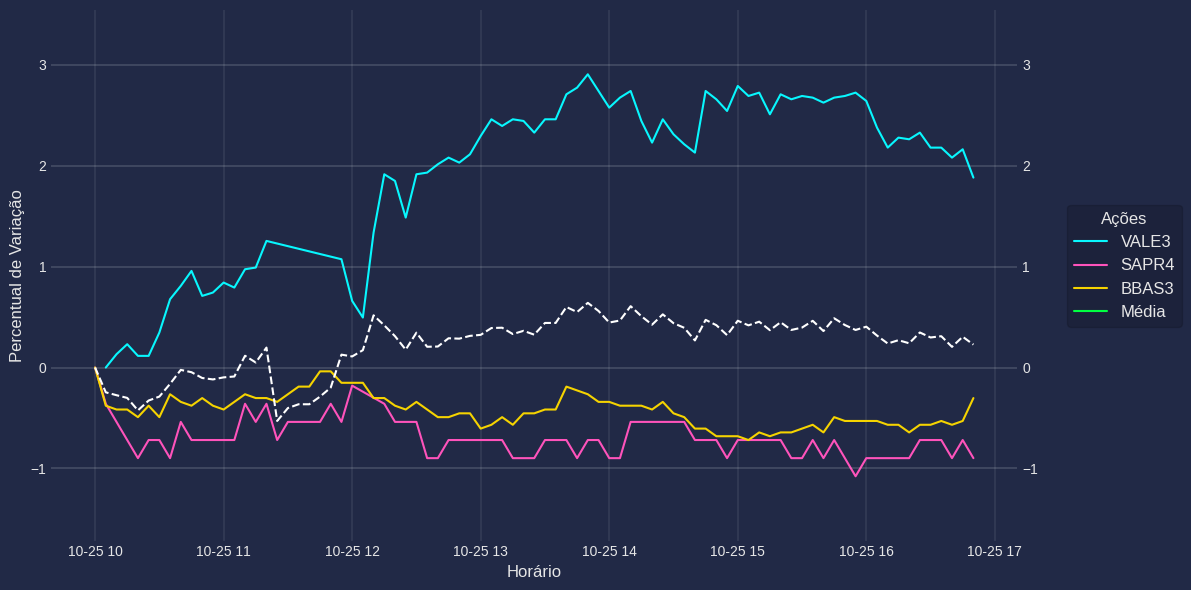

In [87]:
df = pd.read_csv('df_day.csv', parse_dates=['Datetime'])

# lista_acoes = ['VALE3','BBSE3', 'CSAN3', 'RAIZ4', 'BRBI11', 'BBAS3', 'SAPR4', 'SAPR11', 'TRPL4', 'RANI3', 'TAEE11']
lista_acoes = ['VALE3', 'SAPR4', 'BBAS3', 'TRPL4']

mens = mensagem(df, lista_acoes)
print(mens)

fig = grafico(df, lista_acoes, mean=True)
fig.savefig('comparacao_de_acoes.png', dpi=300)

# Enviar e-mail



# Configurar e enviar e-mail


In [445]:
import win32com.client as win32

In [446]:
outlook = win32.Dispatch("outlook.application")
email = outlook.CreateItem(0)

com_error: (-2146959355, 'Falha na execução do servidor', None, None)

In [ ]:
email.To = "rafaelluckner3@gmail.com"
email.Subject = "Seu relatório de Mercado"
email.Body = f'''Prezado cliente, segue o relatório de suas ações:

* O Ibovespa teve o retorno diario de {retorno_ibov}.
* O Dólar teve o retorno diario de {retorno_dolar}.
* O S&P500 teve o retorno diario de {retorno_sp500}.

Segue em anexo a performance dos ativos nos últimos 6 meses.

Att,
Melhor estagiário do mundo


'''
anexo_ibovespa =r"C:\Users\rluckner\Documents\repos\projetos_financeiros\enviar_email\IBOV.png"
anexo_dolar = r"C:\Users\rluckner\Documents\repos\projetos_financeiros\enviar_email\DOLAR.png"
anexo_sp500 = r"C:\Users\rluckner\Documents\repos\projetos_financeiros\enviar_email\S&P500.png"

email.Attachments.Add(anexo_ibovespa)
email.Attachments.Add(anexo_dolar)
email.Attachments.Add(anexo_sp500)

email.Send()